In [453]:
%matplotlib inline
import future
import pylab as plt
import numpy as np
from scipy.spatial import cKDTree
from bornagain import Molecule
from thor import scatter
import mdtraj

In [7]:
from scipy.signal import unit_impulse

from bornagain.simulate import refdata
sig = unit_impulse( (100,100,100), idx='mid') *2*np.pi
crom_mann_coef = refdata.get_cromermann_parameters( range(1,26))



In [240]:
from scipy.special import jn


In [57]:
def mota_intensity( atomic_num, grid_size=2, grid_spacing=0.01):
    Ngrid_pt = int( float(grid_size)/grid_spacing)

    vals = np.arange( -grid_size/2, grid_size/2, grid_spacing)
    
    Qx,Qy,Qz = np.meshgrid( vals,vals,vals, sparse=True)
    QR = np.sqrt( Qx**2 + Qy**2 + Qz**2 )
    QR1 = QR.ravel()

    form_fact = np.zeros( QR1.shape).astype(np.float32)
    
    # this bit makes the form factor
    cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
    xo =  np.power( QR1 , 2) / 16 / np.pi/np.pi
    for i in range(4):    
        form_fact += cromermann[i] * np.exp(-xo * cromermann[i+4])
    
    form_fact += cromermann[-1]
    
    Qbins = np.linspace(0, QR1.max(), int(QR1.max()/grid_spacing/3))
    
    form_fact_1d = np.histogram( QR1, bins=Qbins, weights=form_fact)[0]
    norm = np.histogram( QR1, bins=Qbins)[0]
    form_fact_1d = np.nan_to_num( form_fact_1d/norm )
    Qs = Qbins[1:]*.5 + Qbins[:-1]*.5
    return form_fact.reshape( (Ngrid_pt, Ngrid_pt, Ngrid_pt)), (form_fact_1d,Qs ) 

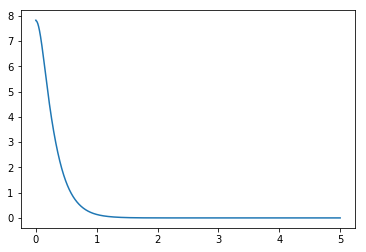

In [281]:
###################
# THIS GETS THE 1D density

atomic_num = 2
R1 = np.linspace( 0, 5, 10000)

rho = np.zeros( R1.shape).astype(np.float32)

# this bit makes the form factor
cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
xo = 4.0 * (np.pi ** 2) * np.power( R1 , 2)
for i in range(4):
    rho += cromermann[i] * np.exp(-xo/cromermann[i+4])\
        / np.power(cromermann[i+4], 0.5 )

rho *= 2 * np.sqrt(2) * np.pi

rho[0] += np.sqrt( 2*np.pi ) * cromermann[-1] 
plt.plot( R1, rho)

0.005000050000500005


(0, 20)

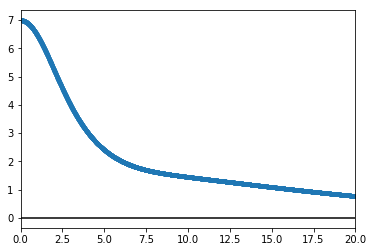

In [316]:
atomic_num = 7

QR1 = np.linspace( 0,500,100000)
print QR1[1] - QR1[0]
form_fact = np.zeros( QR1.shape)

# this bit makes the form factor
cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
xo =  np.power( QR1 , 2) / 16 / np.pi/np.pi
for i in range(4):    
    form_fact += cromermann[i] * np.exp(-xo * cromermann[i+4])

form_fact += cromermann[-1]
plt.hlines( 0, 0,40)

idx = np.where( form_fact < 0)[0]
if idx.size:
    idx = idx[0]
    form_fact[ idx:] = 0
plt.plot( QR1, form_fact, '.')
plt.xlim(0,20)

(0, 1.5)

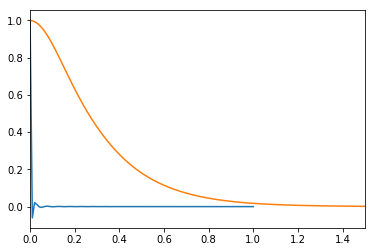

In [313]:
####
# Transform method 1:
R = np.linspace( 0,1, 100)
delQ = QR1[1] - QR1[0]
vals = []
for r in R:
    val = np.mean( np.sinc( QR1 * r / np.pi ) * form_fact * QR1**2 * delQ)
    vals.append( val)
vals = np.array( vals) * 4 * np.pi
plt.plot( R, vals/ vals.max())
plt.plot( R1, rho/rho.max())
plt.xlim(0,1.5)

/Users/damende/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


(0, 1.5)

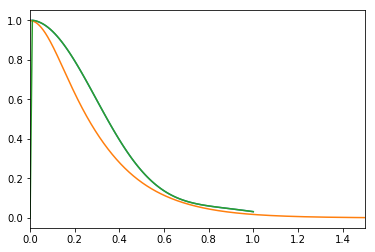

In [291]:
#######
# transform method 2
R = np.linspace( 0,1,100)
delQ = QR1[1]-QR1[0]
vals2 =[]
for r in R:
    val = np.sum( np.power( 2*np.pi, 1.5) * np.sqrt( QR1) * form_fact * jn(1/2., r*QR1) * QR1 ) * delQ
    vals2.append( val)
vals2 = np.nan_to_num( np.array( vals2) / np.sqrt(R) ) 
plt.plot( R, vals/ vals.max())
plt.plot( R1, rho/rho.max())
plt.plot( R, vals2/vals2.max())
plt.xlim(0,1.5)

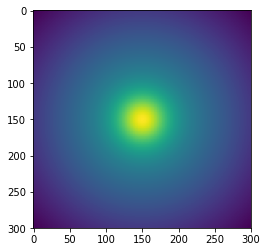

In [65]:
form_fact,( form_fact1d, Qs  )= mota_intensity(7, grid_size=30, grid_spacing=0.1)
plt.imshow( form_fact.mean(0))

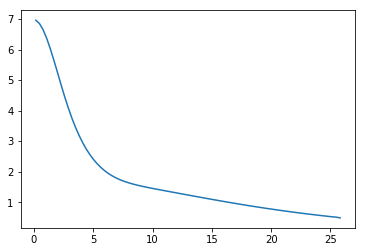

In [66]:
plt.plot( Qs, form_fact1d)

In [441]:
from loki.utils.postproc_helper import is_outlier

def single_atom_dens(atomic_num, grid_size=3, grid_spacing=0.05,
                    filter_atomic_core=True, filter_thresh=50, 
                    filter_sig=5):
    """
    atomic_num, atomic number of element 
    grid_size, size of cubic density grid in Angstrom
    grid_spacing, spacing of cubic grid in Angstrom
    filter_atomic_core, whether to filter the faulty density at atomic core
    """
    #print atomic_num
    Ngrid_pt = int( float(grid_size)/grid_spacing)

    vals = np.arange( -Ngrid_pt/2, Ngrid_pt/2)  * grid_spacing #, grid_spacing)
    
    x,y,z = np.meshgrid( vals,vals,vals, sparse=True)
    R = np.sqrt( x**2 + y**2 + z**2 )
    R1 = R.ravel()

    rho = np.zeros( R1.shape).astype(np.float32)
    
    # this bit makes the form factor
    cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
    xo = 4.0 * (np.pi ** 2) * np.power( R1 , 2)
    for i in range(4):    
        rho += cromermann[i] * np.exp(-xo/cromermann[i+4])\
            / np.power(cromermann[i+4], 0.5 )
    
    rho *=  2 * np.sqrt(2) * np.pi

    if filter_atomic_core:
        dm = rho[ rho > 0].mean()
        s = rho [ rho > 0].std()

        idx = np.where( rho > dm+filter_sig*s)[0]
        vals = rho[ idx]
        bad = is_outlier( vals, filter_thresh)
        fillvalue = vals[~bad].max()
        bad_idx3 = idx[bad]
        rho[ bad_idx3] = fillvalue
        print ("Atom %d, replacing %d densities"%(atomic_num, sum(bad)))

    rho = rho.reshape( (Ngrid_pt, Ngrid_pt, Ngrid_pt))
    
    return rho


In [463]:
traj = mdtraj.load_pdb("2LYZ.pdb")
atoms = list(traj.top.atoms)
atomic_nums = [a.element.atomic_number for a in atoms]
atom_vecs = traj.xyz[0] * 10
atom_vecs -= atom_vecs.mean(0)

unique_atoms = np.unique([a.element.atomic_number for a in atoms] )
unique_atom_dens = {n:single_atom_dens(n, grid_size=4, 
                        grid_spacing=0.2, filter_thresh=1000, 
                        filter_atomic_core=True, filter_sig=0) 
                for n in unique_atoms}

res = 0.2
grid_size = 100.
Npt = int(float(grid_size)/res)
vals = np.arange( -Npt/2,Npt/2)*res

n = unique_atom_dens[ unique_atom_dens.keys()[0]].shape[0]
print len(atom_vecs)

Atom 6, replacing 0 densities
Atom 7, replacing 1 densities
Atom 8, replacing 0 densities
Atom 16, replacing 0 densities
1102


In [474]:
import sys
dens = np.zeros( (Npt,Npt,Npt), dtype=np.float32)
for atom_i,(a,Z) in enumerate(zip( atom_vecs, atomic_nums)):
    sys.stdout.flush()
    grid_pt = np.floor( ( a - vals[0]) / res).astype(int)
    pts = tuple( [ np.arange( x-n/2, x+n/2).astype(np.int32) for x in grid_pt])
    x,y,z = np.meshgrid( *pts)
    coors =  (x.ravel(), y.ravel(), z.ravel())

    dens[coors] += unique_atom_dens[Z].ravel()
    nn = len( atomic_nums) - atom_i
    print "\r atoms left: %4d"%(nn-1),
    

 atoms left:    0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

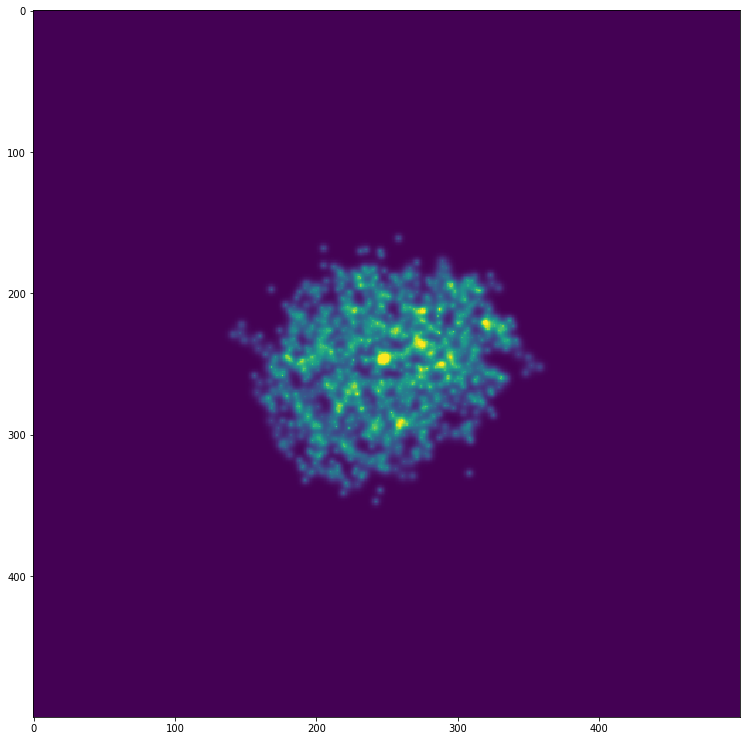

In [482]:
plt.figure(figsize=(13,13))
plt.imshow( dens.mean(0), vmax=0.7)

In [448]:
some_dens = {n:single_atom_dens(n, grid_size=5, grid_spacing=0.2, filter_thresh=1000, 
                filter_atomic_core=True, filter_sig=0) for n in range( 1,26)}

Atom 1, replacing 0 densities
Atom 2, replacing 0 densities
Atom 3, replacing 0 densities
Atom 4, replacing 0 densities
Atom 5, replacing 0 densities
Atom 6, replacing 0 densities
Atom 7, replacing 1 densities
Atom 8, replacing 0 densities
Atom 9, replacing 0 densities
Atom 10, replacing 0 densities
Atom 11, replacing 0 densities
Atom 12, replacing 0 densities
Atom 13, replacing 0 densities
Atom 14, replacing 0 densities
Atom 15, replacing 0 densities
Atom 16, replacing 0 densities
Atom 17, replacing 1 densities
Atom 18, replacing 0 densities
Atom 19, replacing 0 densities
Atom 20, replacing 0 densities
Atom 21, replacing 0 densities
Atom 22, replacing 0 densities
Atom 23, replacing 0 densities
Atom 24, replacing 0 densities
Atom 25, replacing 0 densities


In [451]:
500*500*500*4/1e9

0.5

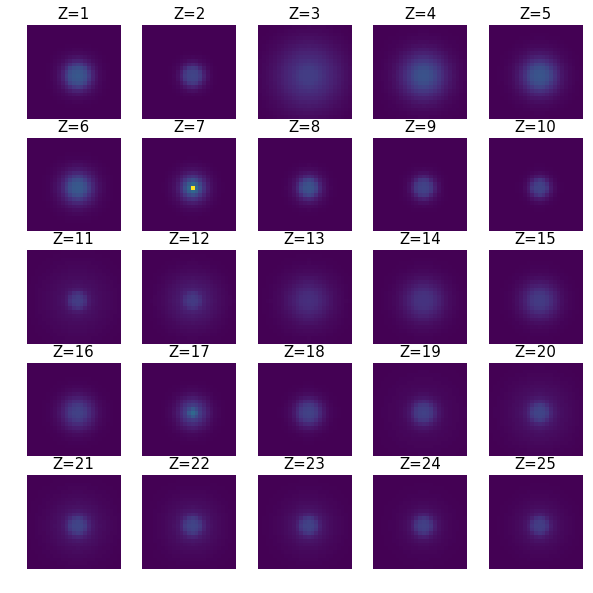

In [434]:
fig,axs = plt.subplots( 5,5, figsize=(10,10))
atom = 1
for i in range (5):
    for j in range(5):
        axs[i][j].clear()
        axs[i][j].imshow( np.mean(some_dens[atom],0), vmax=atom)
        axs[i][j].set_title( "Z=%d"%atom, fontsize=15)
        axs[i][j].axis('off')
        atom += 1

<IPython.core.display.Javascript object>


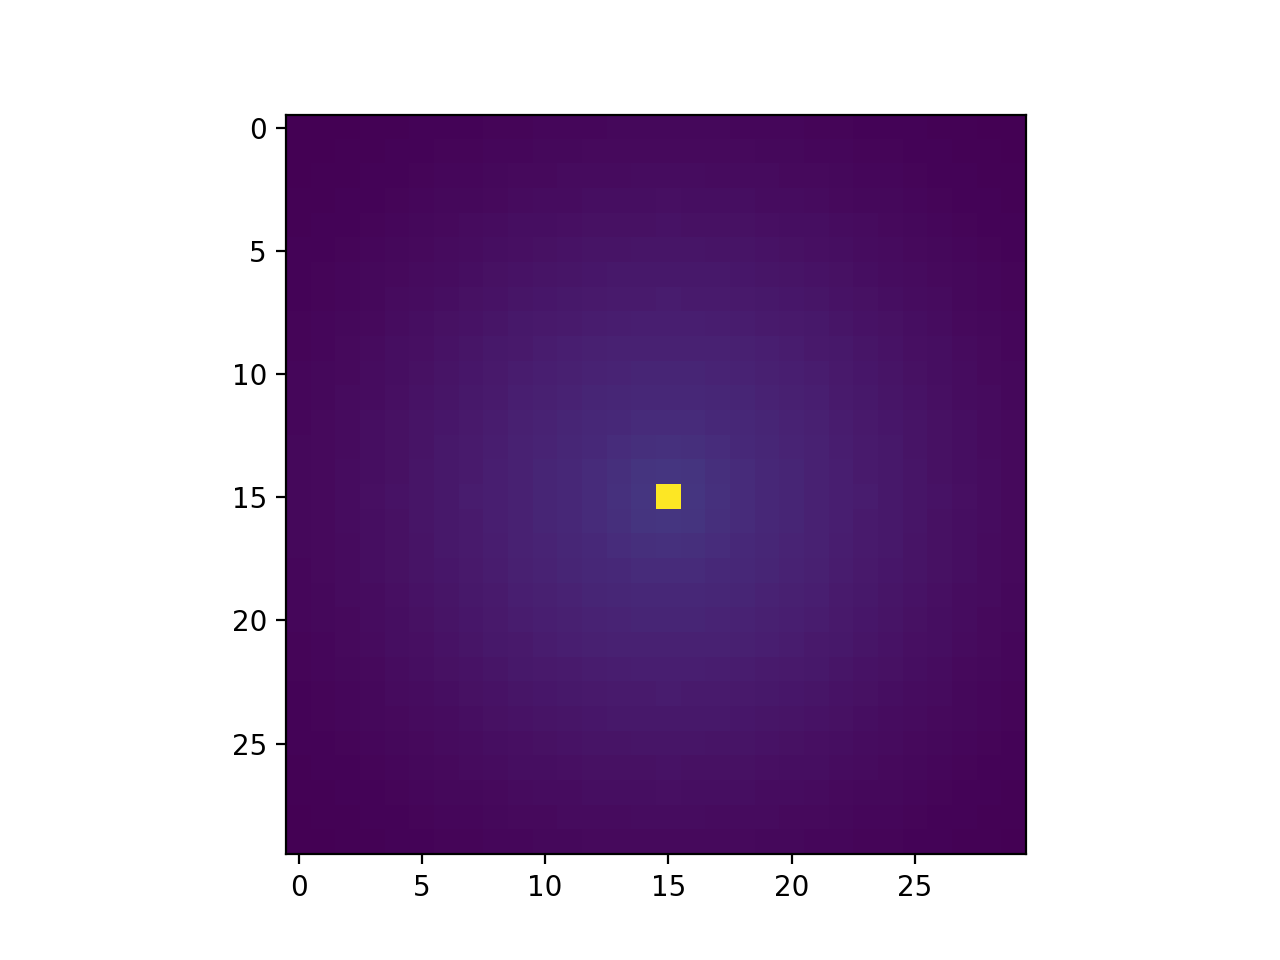

In [319]:

plt.imshow( some_dens[7].mean(0))
plt.show()

In [7]:
def plot_dens(dens, grid_size, **kwargs):
    plt.figure(figsize=(16,12))
    extent = (-grid_size/2, grid_size/2, grid_size/2, -grid_size/2)
    plt.subplot(131);plt.imshow( np.sum( dens, axis=2), extent=extent, **kwargs);plt.title("view along x-y");plt.ylabel('Angstrom')
    plt.subplot(132);plt.imshow( np.sum( dens, axis=1), extent=extent, **kwargs);plt.title("view along x-z");plt.xlabel('Angstrom')
    plt.subplot(133);plt.imshow( np.sum( dens, axis=0),extent=extent, **kwargs);plt.title("view along y-z")

make grid
make coors
make tree


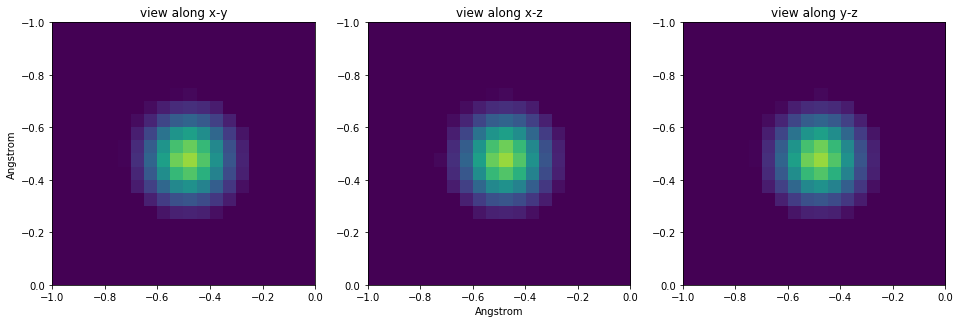

In [257]:
# define a grid around a single atom
def single_atom_dens(grid_size=1.5, grid_spacing=0.05)
    #grid_size = 1.5 # angstrom
    #grid_spacing = 0.05 # angstrom
    Ngrid_pt = grid_size/grid_spacing

    print("make grid")

    vals = np.linspace( -grid_size/2, grid_size, Ngrid_pt, endpoint=True)
    
    #x,y,z = np.mgrid[
    #        -grid_size/2.:grid_size/2.:Ngrid_pt*1j, 
    #        -grid_size/2.:grid_size/2.:Ngrid_pt*1j, 
    #        -grid_size/2.:grid_size/2.:Ngrid_pt*1j]

    x,y,z = np.meshgrid( vals,vals,vals, sparse=True)
    R = np.qsrt( x**2 + y**2 + z**2 )
    #coors = np.zeros( (Ngrid_pt**3,3), dtype=np.float32)
    #coors[:,0] = x.ravel()
    #coors[:,1] = y.ravel()
    #coors[:,2] = z.ravel()
    
    #print("make coors")
    #coors = np.array( zip(x.ravel(), y.ravel(), z.ravel() ))
    #print("make tree")
    #KD_grid = cKDTree(coors)

    #single_atom = np.zeros( Ngrid_pt**3, dtype=np.float32)
    
    #lucky_atom = 2
    #distances, grid_pos =KD_grid.query( [0.02,0.02,0.02], k=500, distance_upper_bound=3.5)
    #n_neighbors = len([ d for d in distances if d != np.inf])
    #distances, grid_pos = distances[:n_neighbors],  grid_pos[:n_neighbors]

    #grid_idx = np.unravel_index( grid_pos, single_atom.shape)
    
    form_fact = scatter.atomic_electrondens( atomic_num, R.ravel() )

    return form_fact
    #single_atom += form_fact

    #plot_dens( single_atom, grid_size, vmax=50)


In [2]:
# define a grid
grid_size = 160 # angstrom
grid_spacing = 1 # angstrom
Ngrid_pt = grid_size/grid_spacing

# load a molecule
#mol = Molecule("2LYZ.pdb")
#mol.atom_vecs -= mol.atom_vecs.mean(0)

In [3]:
from scipy.spatial import distance
print (distance.pdist(mol.atom_vecs).max())

NameError: name 'mol' is not defined

In [5]:
# originally wanted to used histogramdd, but then realized it fails for fine grids.. 
import numpy as np
bins_on_d = np.linspace( - int(grid_size/2), int(grid_size/2), int(Ngrid_pt))
dens_bad = np.histogramdd(  atom_vecs, [bins_on_d]*3, weights=atomic_nums )[0]
plot_dens( dens_bad, grid_size)

NameError: name 'atom_vecs' is not defined

In [22]:
# so do a nearest neighbor assignment

print("make grid")

x,y,z = np.mgrid[
        -grid_size/2:grid_size/2:Ngrid_pt*1j, 
        -grid_size/2:grid_size/2:Ngrid_pt*1j, 
        -grid_size/2:grid_size/2:Ngrid_pt*1j]

print("make coors")
coors = np.array( zip(x.ravel(), y.ravel(), z.ravel() ))
print("make tree")
KD_grid = cKDTree(coors)

make grid
make coors
make tree


In [23]:
# this works for fixed atom size
atom_size = 1.5
nearest_gridpts_to_atoms = KD_grid.query_ball_point( mol.atom_vecs, r=atom_size)

In [24]:
dens = np.zeros( x.shape)
for i,nearest in enumerate( nearest_gridpts_to_atoms):
    if not nearest:
        continue
    idx = np.unravel_index( nearest, x.shape)
    dens[idx] += mol.Z[i]

In [33]:
idx

(array([77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78]),
 array([73, 73, 73, 74, 74, 74, 73, 73, 73, 74, 74, 74]),
 array([96, 97, 98, 96, 97, 98, 96, 97, 98, 96, 97, 98]))

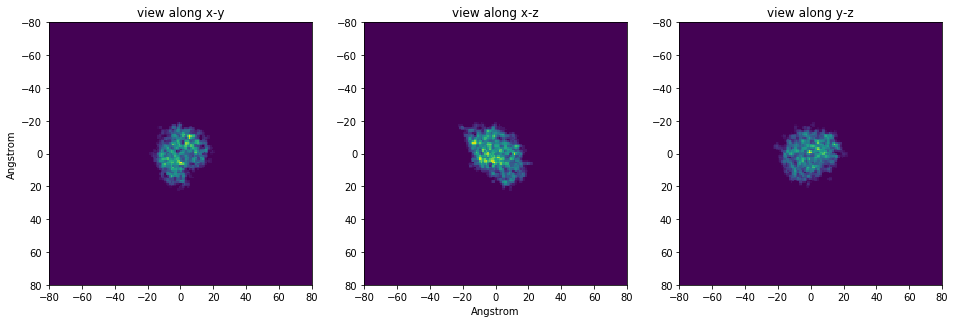

In [25]:
plot_dens(dens, grid_size)

In [13]:
%%time

## here I demo how to make another grid using form factors and TJ code
dens_crom_mann = np.zeros_like( dens)
for i, (atom,Z) in enumerate(zip(mol.atom_vecs, mol.Z)):
    
    distances, grid_pos =KD_grid.query( atom, k=500, distance_upper_bound=3)
    n_neighbors = len([ d for d in distances if d != np.inf])
    distances, grid_pos = distances[:n_neighbors],  grid_pos[:n_neighbors]

    grid_idx = np.unravel_index( grid_pos, dens.shape)

    form_fact = scatter.atomic_electrondens( Z, distances )

    dens_crom_mann[grid_idx] += form_fact

CPU times: user 383 ms, sys: 3.94 ms, total: 386 ms
Wall time: 397 ms


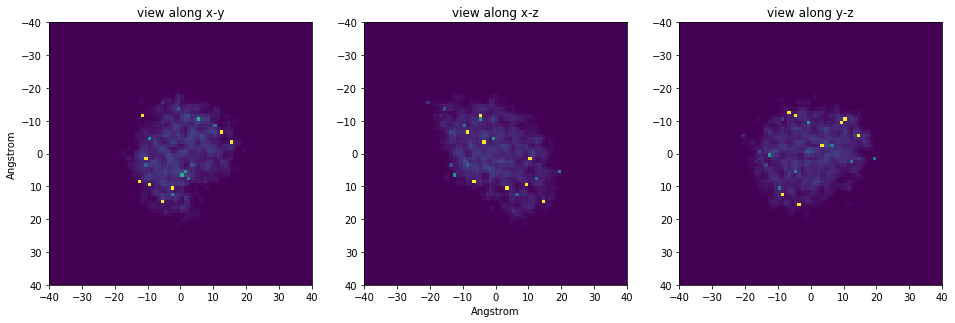

In [14]:
# with atomic gaussians
plot_dens( dens_crom_mann, grid_size, vmax=10)

In [485]:
%%time
from scipy.fftpack import fftn, fftshift, fftfreq
Nfft = dens.shape[0]*2
diffrac = np.abs(fftshift(fftn(dens, shape=[Nfft,Nfft,Nfft])))**2

CPU times: user 1min 10s, sys: 1min 43s, total: 2min 54s
Wall time: 5min 46s


In [495]:

qmags = 2*np.pi*fftshift( fftfreq(Nfft, 0.2) )
qmin, qmax = qmags.min(), qmags.max()

Text(0.5,1,'view along qy-qz')

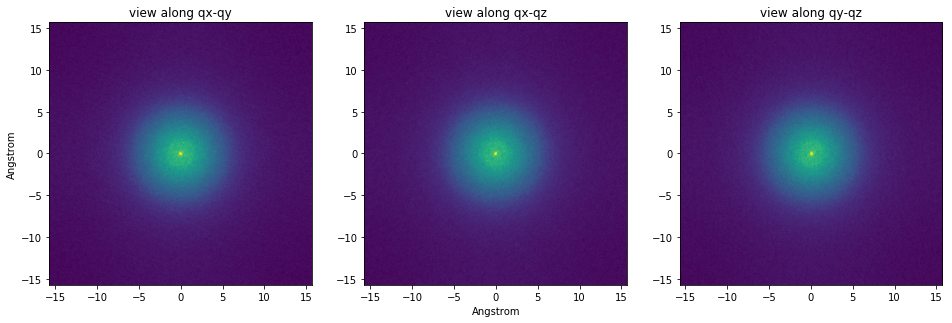

In [496]:
plt.figure(figsize=(16,12))
extent = (qmin, qmax, qmin, qmax)
plt.subplot(131);plt.imshow( np.sum( diffrac, axis=2), extent=extent , norm=plt.mpl.colors.LogNorm());plt.title("view along qx-qy");plt.ylabel('Angstrom')
plt.subplot(132);plt.imshow( np.sum( diffrac, axis=1), extent=extent,norm=plt.mpl.colors.LogNorm());plt.title("view along qx-qz");plt.xlabel('Angstrom')
plt.subplot(133);plt.imshow( np.sum( diffrac, axis=0), extent=extent,norm=plt.mpl.colors.LogNorm());plt.title("view along qy-qz")

In [ ]:
diffrac_crom_mann = np.abs(fftshift(fftn(dens, shape=[Nfft,Nfft,Nfft])))**2

plt.figure(figsize=(16,12))
extent = (qmin, qmax, qmin, qmax)
plt.subplot(131);plt.imshow( np.sum( diffrac_crom_mann, axis=2), extent=extent , norm=plt.mpl.colors.LogNorm());plt.title("view along qx-qy");plt.ylabel('Angstrom')
plt.subplot(132);plt.imshow( np.sum( diffrac_crom_mann, axis=1), extent=extent,norm=plt.mpl.colors.LogNorm());plt.title("view along qx-qz");plt.xlabel('Angstrom')
plt.subplot(133);plt.imshow( np.sum( diffrac_crom_mann, axis=0), extent=extent,norm=plt.mpl.colors.LogNorm());plt.title("view along qy-qz")

In [ ]:
from scipy.interpolate import RegularGridInterpolator as RGI
Interp = RGI([qmags]*3, diffrac)

In [489]:
from bornagain import SimplePAD
pad = SimplePAD( pixsize=0.0001, detdist=0.1, wavelen=1.305, n_pixels=512)
q_pixels = pad.Q_vectors

In [490]:
%%time 
img = Interp( q_pixels).reshape( pad.img_sh)

CPU times: user 211 ms, sys: 19.3 ms, total: 230 ms
Wall time: 133 ms


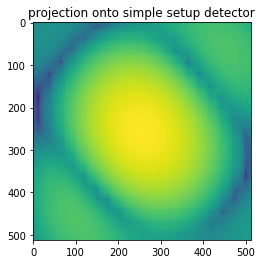

In [491]:
# plot the interpolation on the detector
plt.imshow( img, norm=plt.mpl.colors.LogNorm() )
_=plt.title("projection onto simple setup detector")

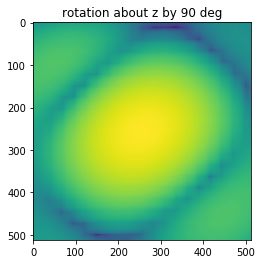

In [492]:
# rotate the molecule about Z-axis 90 degrees
Rot90 = np.array([[0,-1,0], [1, 0, 0], [0, 0, 1]])
q_pixels_R90 = np.dot( Rot90.T, q_pixels.T).T # left multiply

imgR90 = Interp( q_pixels_R90).reshape( pad.img_sh)
plt.imshow( imgR90, norm=plt.mpl.colors.LogNorm() )
_=plt.title("rotation about z by 90 deg")

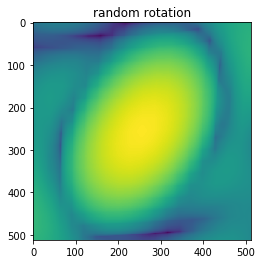

In [493]:
# do a random rotation
from bornagain.utils import random_rotation as RandRot

q_pixels_randrot = np.dot( RandRot().T, q_pixels.T).T
img_randrot = Interp( q_pixels_randrot).reshape( pad.img_sh)
plt.imshow( img_randrot, norm=plt.mpl.colors.LogNorm() )
_=plt.title("random rotation")

In [238]:
50 / 0.02

2500.0

In [240]:
2500*2500*2500*4/1e9

62.5

In [259]:
from scipy.interpolate import LinearNDInterpolator as LNI
LNInterp = LNI([qmags]*3, diffrac.ravel())

ValueError: different number of values and points

In [270]:
qx,qy,qz = np.meshgrid( qmags, qmags, qmags)

q3 = np.array(zip( qx.ravel(), qy.ravel(), qz.ravel()))

In [ ]:
LNI( q3, diffrac.ravel())

In [41]:
def single_atom_dens(atomic_num, grid_size=2., grid_spacing=0.05):
    Ngrid_pt = int(grid_size/grid_spacing)

    vals = np.arange( -grid_size/2, grid_size/2, grid_spacing)
    #vals = np.linspace( -grid_size/2, grid_size, Ngrid_pt, endpoint=True)
    x,y,z = np.meshgrid( vals,vals,vals, sparse=True)
    R = np.sqrt( x**2 + y**2 + z**2 )
    form_fact = scatter.atomic_electrondens( atomic_num, R.ravel() )

    return form_fact.reshape( (Ngrid_pt, Ngrid_pt, Ngrid_pt))

In [42]:
dens = single_atom_dens( 1)

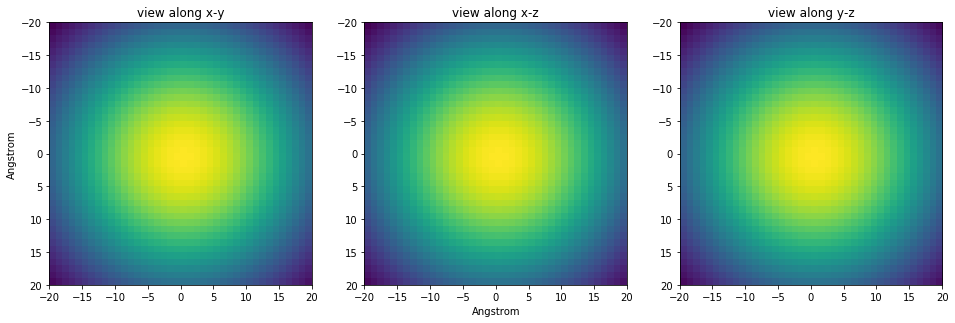

In [43]:
plot_dens( dens, dens.shape[0])

In [47]:
dens = zeros( (Npt,Npt,Npt), dtype=np.float32)
for atom_i,(a,Z) in enumerate(zip( atom_vecs, atomic_nums)):
    grid_pt = np.floor( ( a - vals[0]) / res).astype(int)
    pts = tuple( [ arange( x-50, x+50).astype(np.int32) for x in grid_pt])
    x,y,z = meshgrid( *pts)
    #coors = zeros( (100*3,3), dtype=np.float32)
    coors =  (x.ravel(), y.ravel(), z.ravel())
    #coors[:,1] = y.ravel()
    #coors[:,2] = z.ravel()
    
    dens[coors] += unique_atom_dens2[Z]
    print atom_i
    print grid_pt